<a href="https://colab.research.google.com/github/dmamur/struct2prop/blob/main/add/embed_mp2022_phdos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle,re, glob,os,random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Embedding,Dense,Dropout,Input,Concatenate,Flatten,Bidirectional,LSTM,Reshape
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import keras.backend as K
from collections import defaultdict

In [2]:
!git clone https://github.com/dmamur/struct2prop.git
!git clone https://github.com/ninarina12/phononDoS_tutorial.git
%cd phononDoS_tutorial

fatal: destination path 'struct2prop' already exists and is not an empty directory.
fatal: destination path 'phononDoS_tutorial' already exists and is not an empty directory.
/content/phononDoS_tutorial


In [3]:
class Config:
    MAX_LEN = 64
    BATCH_SIZE = 1
    LR = 0.001
    VOCAB_SIZE = 128
    EMBED_DIM = 128
    MNAME = 'embed_'
config = Config()
path="/content/struct2prop/models"
mname=path+config.MNAME+'E_'+str(config.EMBED_DIM)
tf.random.set_seed(42)

In [4]:
!pip install ase

# Load data from CIF

In [5]:
from ase.io import read
from ase import Atoms
from scipy.ndimage import gaussian_filter1d
from ase.neighborlist import neighbor_list
from scipy.interpolate import interp1d

def getpdf(atoms,x,v):
    i, d = neighbor_list('id', atoms, 10.0, self_interaction=False)
    pdfatoms=[]
    for k,l in enumerate(atoms):
        y = np.zeros(100)
        dist = np.round(d[i==k]*10)
        a,b=np.unique(dist, return_counts=True)
        np.put(y,a.astype(int)-1,b)
        pdfatoms.append(gaussian_filter1d(y/v,1))
    return np.asarray(pdfatoms)

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
def getInterp(x,y,numpts=128,maxfreq=1200,nfilter=3):
    if np.max(x)<maxfreq:
        maxfreq=np.max(x)
    xnew = np.linspace(0, maxfreq, num=numpts, endpoint=True)
    f = interp1d(x, y, fill_value="extrapolate")
    return xnew,smooth(f(xnew),nfilter)


In [6]:
# load data
df = pd.read_csv('data/data.csv')
df.head()

,mp_id,structure,phfreq,phdos,pdos
0,mp-1000,"{'numbers': [56, 52], 'positions': [[0.0, 0.0,...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.1603814665137704, 0.366293016390463, 0...","{'Ba': [0.0, 0.17004785173719497, 0.4321591874..."
1,mp-1002124,"{'numbers': [72, 6], 'positions': [[0.0, 0.0, ...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.02337731725373556, 0.030910686260937723, 0....","{'Hf': [0.026541048236378005, 0.03587084551615..."
2,mp-1002164,"{'numbers': [32, 6], 'positions': [[0.0, 0.0, ...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.0017221473876927959, 0.005981246148731...","{'Ge': [0.0, 0.00316167053214679, 0.0109190651..."
3,mp-10044,"{'numbers': [5, 33], 'positions': [[4.44089209...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.002277293012378372, 0.0078646582782471...","{'B': [0.0, 0.00029269193672558846, 0.00105324..."
4,mp-1008223,"{'numbers': [20, 34], 'positions': [[0.0, 0.0,...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.258870972416879, 0.5505201512544314, 0...","{'Ca': [0.0, 0.11150000312651394, 0.2215562000..."


In [8]:
r = np.arange(0,10,0.1)
v = np.concatenate([[1],4*np.pi/3*(r[1:]**3 - r[:-1]**3)])
types,formula,ids,pdf,phdos = [],[],[],[],[]
for index, row in df.iterrows():
  atoms=Atoms.fromdict(eval(row['structure']))
  formula.append(atoms.get_chemical_formula())
  types.append(atoms.get_chemical_symbols())
  pdf.append(getpdf(atoms,r,v))
ids=df['mp_id'].to_list()

In [9]:
# Load data for masked language model
with open('/content/struct2prop/data/el2id.pkl', 'rb') as f:
    el2id = pickle.load(f)
element2id = el2id['el2id']
config.VOCAB_SIZE = len(element2id)
print(config.VOCAB_SIZE)

94


In [10]:
# load data
with open('/content/struct2prop/add/phdos_refSpectra.pkl', 'rb') as f:
    db = pickle.load(f)
print(db.keys())

dosfreq,phdos = [],[]
coef = 29.9
for i,j in zip(db['freq'],db['phdos']):
  i0,j0 = getInterp(i*coef,j,numpts=128,maxfreq=35*coef,nfilter=1)#
  dosfreq.append(i0)
  phdos.append(j0)

dict_keys(['ids', 'freq', 'phdos'])


In [11]:
typesNumerical=[]
for i in types:
    typesNumerical.append([element2id[j] for j in i])

material_ide3nn = df['mp_id'].to_list()
material_id = db['ids']
indx=[]
for i in material_id:
  indx.append(material_ide3nn.index(i))


x1 = tf.keras.preprocessing.sequence.pad_sequences(pdf,dtype='float32',padding= 'post',maxlen=config.MAX_LEN )[indx]
x1[np.isnan(x1)]=0
x2 = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical,dtype='int32',padding= 'post',maxlen=config.MAX_LEN)[indx]

In [12]:
x3  = tf.keras.preprocessing.sequence.pad_sequences(dosfreq,dtype='float32')
y  = tf.keras.preprocessing.sequence.pad_sequences(phdos,dtype='float32')
p = np.random.RandomState(seed=73).permutation(y.shape[0])
n = len(p)
trainidx = p[:int(n*0.8)]
validx = p[int(n*0.8):int(n*0.9)]
testidx = p[int(n*0.9):]

# Predict PhDOS
I shall use x_train2 as y_train but after replacing 20% of atoms with 0

In [13]:
inputA = Input(shape=x1.shape[1:],name='x1')
inputC = Input((config.MAX_LEN), dtype=tf.int32,name='types')
outNeuronNum = y.shape[1]
inputD = Input(shape=x3.shape[1:],)
outNeuronNum = x3.shape[1]

#inputD = Input(shape=outNeuronNum,)

x = Bidirectional(LSTM(8,name='x1_lstm',return_sequences=True),name='x1_blstm')(inputA)
x = Model(inputs=inputA, outputs=x)

z =  Embedding(config.VOCAB_SIZE, config.EMBED_DIM, mask_zero=True,name="element_embdgs")(inputC)
z = Model(inputs=inputC, outputs=z)

d = Dense(config.MAX_LEN, activation="linear",use_bias=True)(inputD)
d = Reshape((config.MAX_LEN,1))(d)
d = Dropout(0.1)(d)
d = Model(inputs=inputD, outputs=d)

combined = Concatenate()([x.output,z.output,d.output])

l = LSTM(256)(combined)

e = Dense(outNeuronNum, activation="relu",use_bias=True,name='out_edos')(l)
model = Model(inputs=[x.input, z.input, d.input], outputs=[e])

mname = mname+'_phDOS'


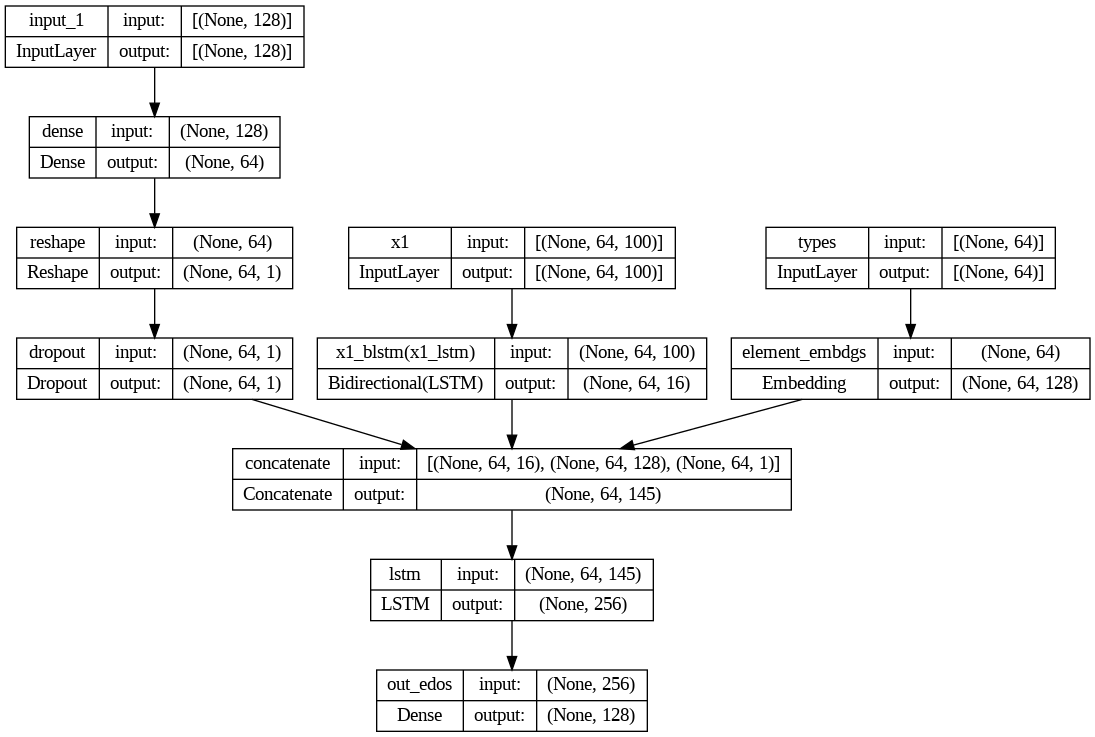

In [14]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [15]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 64)                   8256      ['input_1[0][0]']             
                                                                                                  
 x1 (InputLayer)             [(None, 64, 100)]            0         []                            
                                                                                                  
 types (InputLayer)          [(None, 64)]                 0         []                            
                                                                                            

In [16]:
model.compile(loss ='mae',
              optimizer= keras.optimizers.Adam(learning_rate=config.LR),
              metrics='mse')

In [31]:
def scheduler(epoch):
    initial_lrate = config.LR
    drop = 0.92
    epochs_drop = 2
    lr = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    if lr<0.0001:
        lr = 0.0001
    return lr

epochs=30*config.BATCH_SIZE
csv_logger = tf.keras.callbacks.CSVLogger(mname+"_log.csv", append=True)
earlyStopping= tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, min_delta=0.01)
checkpoint = tf.keras.callbacks.ModelCheckpoint(mname+".h5",verbose=2,monitor='val_loss', mode='min',save_freq=5000)
callbacks_list = [checkpoint,csv_logger,earlyStopping,tf.keras.callbacks.LearningRateScheduler(scheduler)]

hist = model.fit(x=[x1[trainidx], x2[trainidx], x3[trainidx]], y=[y[trainidx]],
                 validation_data=([x1[validx], x2[validx], x3[validx]], [y[validx]]),
                 initial_epoch = 0, epochs = epochs,batch_size = 32,callbacks = callbacks_list, verbose=1)


Epoch 1/30
38/38 [==============================] - 17s 447ms/step - loss: 0.8870 - mse: 2.5957 - val_loss: 0.8827 - val_mse: 2.5458 - lr: 0.0010
Epoch 2/30
38/38 [==============================] - 15s 396ms/step - loss: 0.8728 - mse: 2.5624 - val_loss: 0.9147 - val_mse: 2.5719 - lr: 9.2000e-04
Epoch 3/30
38/38 [==============================] - 14s 371ms/step - loss: 0.8682 - mse: 2.5358 - val_loss: 0.8816 - val_mse: 2.4743 - lr: 9.2000e-04
Epoch 4/30
38/38 [==============================] - 15s 388ms/step - loss: 0.8525 - mse: 2.4723 - val_loss: 0.9073 - val_mse: 2.4920 - lr: 8.4640e-04
Epoch 5/30
38/38 [==============================] - 14s 381ms/step - loss: 0.8492 - mse: 2.4506 - val_loss: 0.8591 - val_mse: 2.4922 - lr: 8.4640e-04
Epoch 6/30
38/38 [==============================] - 14s 375ms/step - loss: 0.8497 - mse: 2.4454 - val_loss: 0.8522 - val_mse: 2.4332 - lr: 7.7869e-04
Epoch 7/30
38/38 [==============================] - 14s 382ms/step - loss: 0.8329 - mse: 2.3899 - val_lo

In [38]:
preds = model.predict([x1,x2,x3],batch_size = 32)

dbresults={}
dbresults['x4'] = x3
dbresults['y'] = y
dbresults['preds'] = preds
dbresults['train_idx'] = trainidx
dbresults['validate_idx'] = validx
dbresults['test_idx'] = testidx
dbresults['formula'] = formula
dbresults['ids'] = material_id

with open(mname+'_results.pkl', 'wb') as f:
    pickle.dump(dbresults, f)


MSE_test:  2.3134975 MAE_test:  0.8142664
mean_squared_error:  0.6936283
mean_absolute_error:  0.5255779


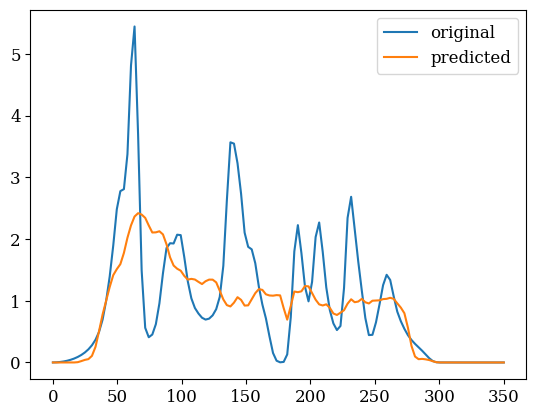

In [39]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,median_absolute_error
ytest    = dbresults['y'][testidx]
x4t      = dbresults['x4'][testidx]
predtest = dbresults['preds'][testidx]
mset = np.asarray([mean_squared_error(i,j) for i,j in zip(ytest,predtest)])
maet = np.asarray([mean_absolute_error(i,j) for i,j in zip(ytest,predtest)])
mseTt=np.mean(mset)
maeTt=np.mean(maet)
print('MSE_test: ',mseTt,'MAE_test: ',maeTt)
#formula = [dbresults['formula'][i] for i in testidx]
#ids = [dbresults['ids'][i] for i in testidx]
ind=np.random.randint(len(ytest))
p = np.random.permutation(np.where(mset>0.)[0])
ind=p[0]#np.random.randint(len(ytrain))
y_true = ytest[ind]
y_pred = predtest[ind]
plt.plot(x4t[ind],y_true,label='original')
plt.plot(x4t[ind],gaussian_filter1d(y_pred,1),label='predicted')
#plt.plot(x4t[ind],gaussian_filter1d(y_true,1))
print('mean_squared_error: ',mean_squared_error(y_true,y_pred))
print('mean_absolute_error: ',mean_absolute_error(y_true,y_pred))
#plt.title(formula[ind].translate(sub), fontsize=16)
plt.legend();

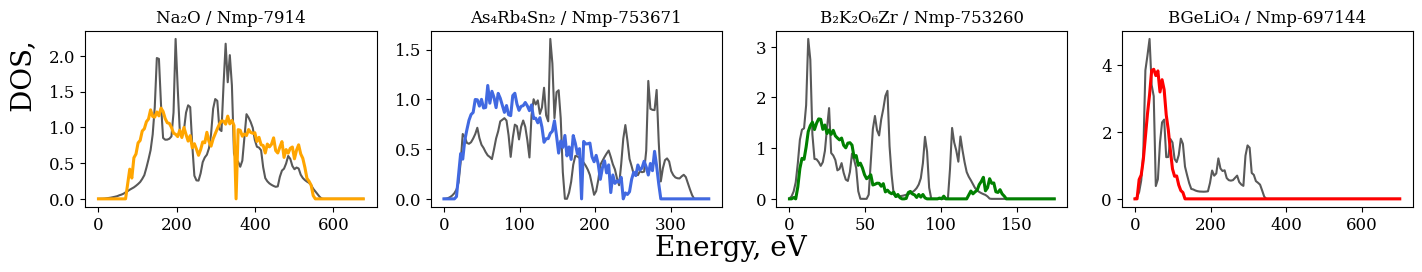